In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [9]:
# creo una funzione utilizzando l'endpoint per ricavare i dati contenuti nelle tabelle del mio db.
# passo dunque un json contenente il nome della tabella e creo un dataframe con i dati ottenuti dalla response
def import_dati_da_db(url, json_data):
    try:
        response = requests.post(url, json=json_data)
        # controllo sulla response
        if response.status_code == 200:
            json_response = response.json()
            df = pd.DataFrame(json_response["data"])
            return df  
        else:
            print(f"errore durante la request: {response.status_code}")
            return None
    except Exception as e:
        print(f"errore: {str(e)}")
        return None

In [10]:
from Tools.scripts.dutree import display

# creazione df per analisi
# da richiedere tramite libreria request al db
#df_vini_rossi = pd.read_csv('https://raw.githubusercontent.com/FabioGagliardiIts/datasets/main/wine_quality/winequality-red.csv', encoding='UTF-8', sep=";")
#df_vini_bianchi = pd.read_csv('https://raw.githubusercontent.com/FabioGagliardiIts/datasets/main/wine_quality/winequality-white.csv', encoding='UTF-8', sep=";")
url = "http://localhost:8000/get"
json_vini_rossi = {
    "table_name" : "dati_vini_rossi"
}
json_vini_bianchi = {
    "table_name" : "dati_vini_bianchi"
}
df_vini_rossi = import_dati_da_db(url, json_vini_rossi)
print(df_vini_rossi) 

df_vini_bianchi = import_dati_da_db(url, json_vini_bianchi)
print(df_vini_bianchi) 

# aggiungo la categoria per i vini
df_vini_rossi['category']='red'
df_vini_bianchi['category']='white'

df_vini = pd.concat([df_vini_rossi, df_vini_bianchi], ignore_index=True)

print(df_vini)

        id  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0        1            7.4             0.700         0.00             1.9   
1        2            7.8             0.880         0.00             2.6   
2        3            7.8             0.760         0.04             2.3   
3        4           11.2             0.280         0.56             1.9   
4        5            7.4             0.700         0.00             1.9   
...    ...            ...               ...          ...             ...   
1594  1595            6.2             0.600         0.08             2.0   
1595  1596            5.9             0.550         0.10             2.2   
1596  1597            6.3             0.510         0.13             2.3   
1597  1598            5.9             0.645         0.12             2.0   
1598  1599            6.0             0.310         0.47             3.6   

      chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  \
0         

In [11]:
# funzioni DATAVIZ
def corr_map (corr_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True)
    plt.show()

def box_plots(data: pd.DataFrame):
    num_columns = data.shape[1]
    num_rows = (num_columns - 1) // 3 + 1
    num_cols = min(num_columns, 3)

    plt.figure(figsize=(15, 12))

    for n, col in enumerate(data.columns, start=1):
        plt.subplot(num_rows, num_cols, n)
        sns.boxplot(data[col])
        plt.title(col)

    plt.tight_layout()
    plt.show()

In [12]:
# Funzioni per pulizia dati
def iqr_range (df, colonna):
    if colonna not in df.columns:
        print(f"La colonna '{colonna}' non esiste nel DataFrame.")
        return

    q1 = df[colonna].quantile(0.25)
    q3 = df[colonna].quantile(0.75)
    iqr = q3 - q1


    low_limit = q1 - 1.5 * iqr
    up_limit = q3 + 1.5 * iqr

    # in questo modo limito i valori al limite inferiore ed al limite superiore definito in precedenza
    df.loc[df[colonna] > up_limit, colonna] = up_limit
    df.loc[df[colonna] < low_limit, colonna] = low_limit

    return df

id                      False
fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
category                False
dtype: bool


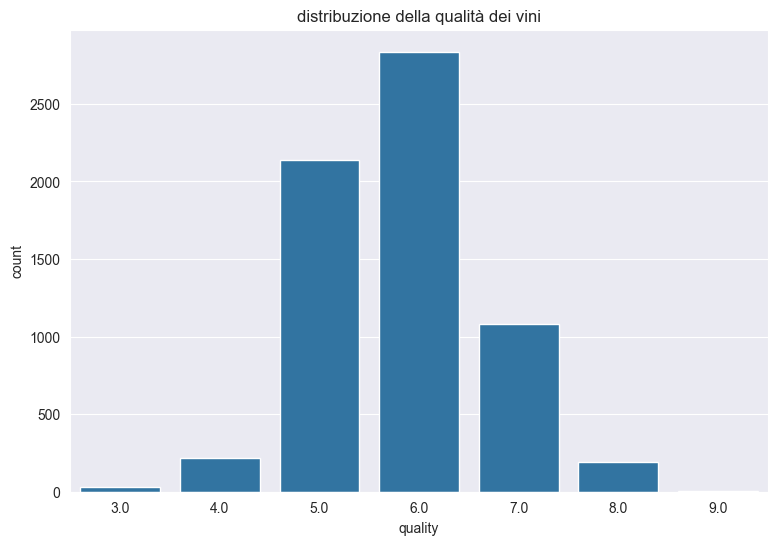

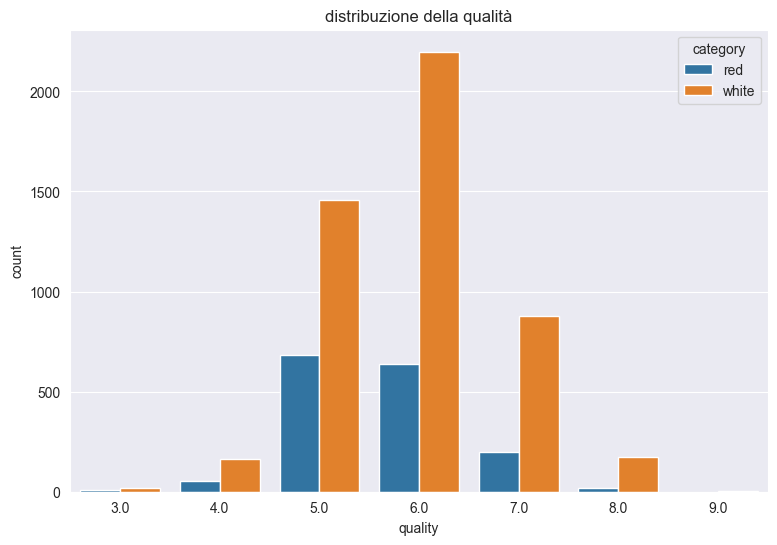

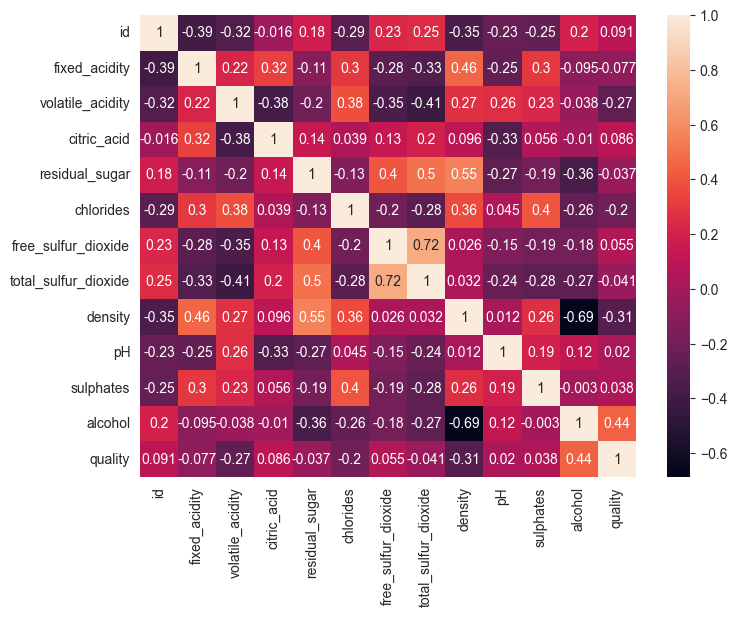

Boxplot prima dell'analisi


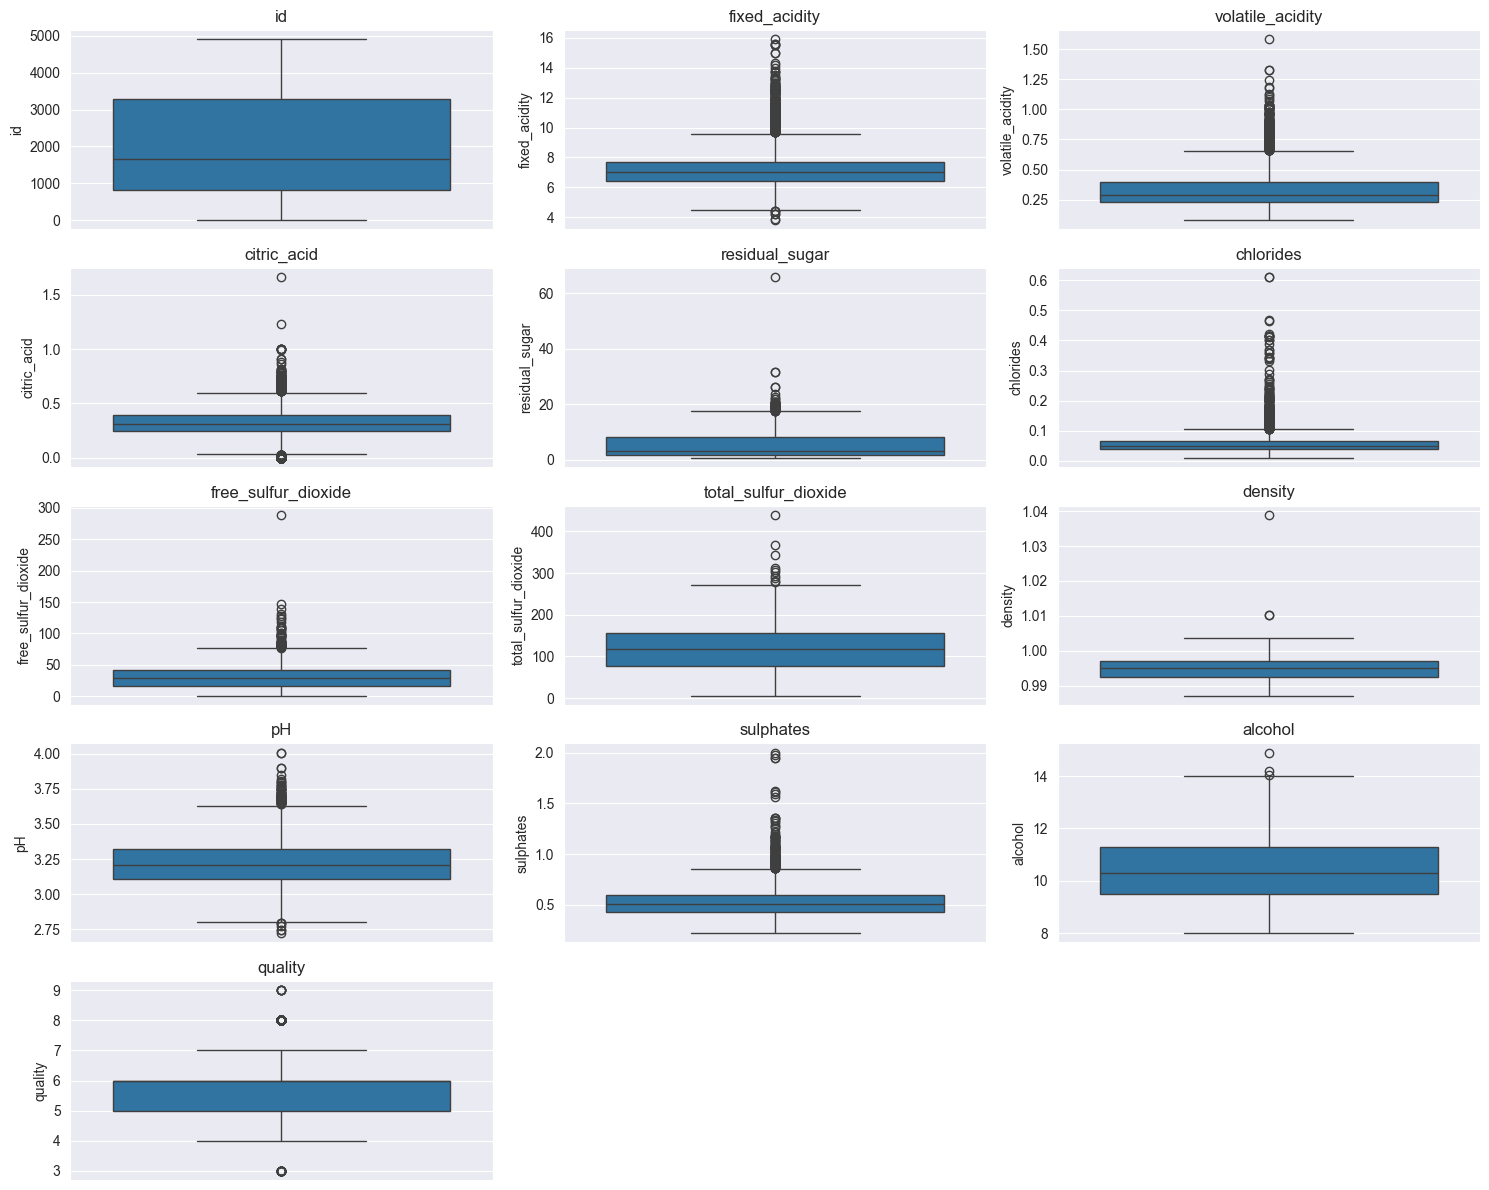

Boxplot dopo l'applicazione dell'iqr_range


C:\Users\lonnis\AppData\Local\Temp\ipykernel_19768\3684247931.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6965.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[colonna] > up_limit, colonna] = up_limit


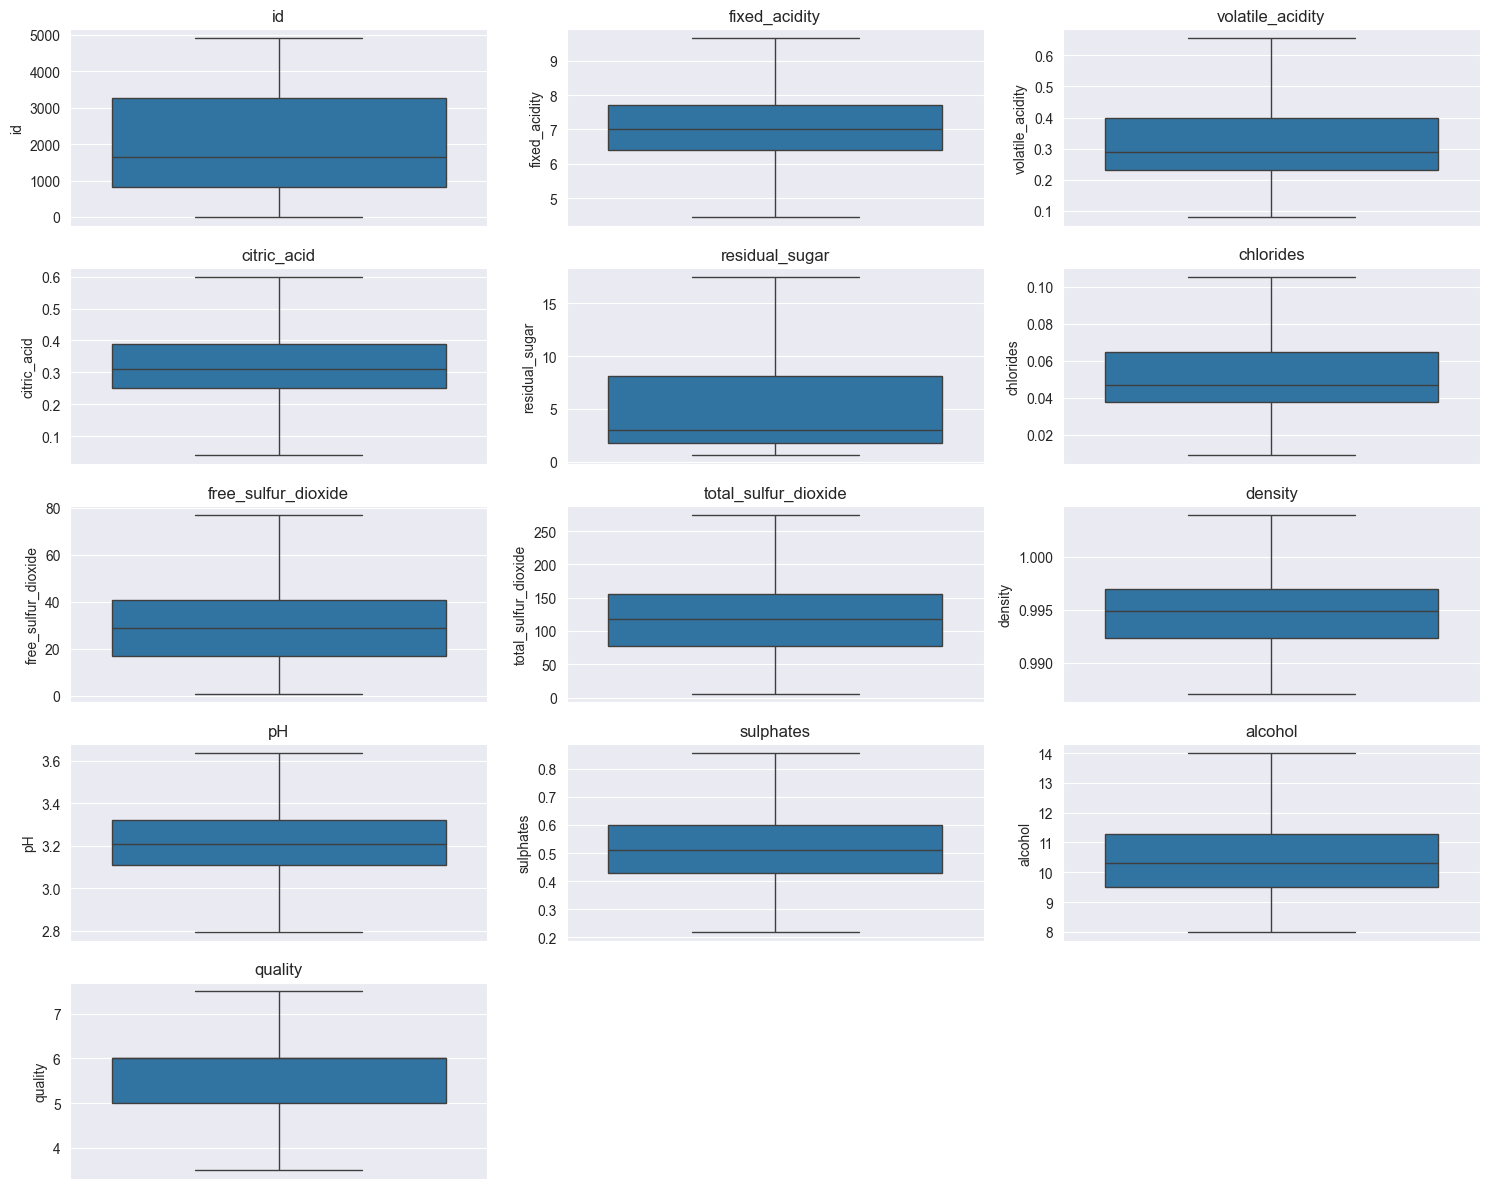

In [13]:
# FASE DI ANALISI
# per prima cosa controllo la presenza di valori nulli nel df anche se dal documento risulta che non ce ne siano
print(df_vini.isnull().any())

# controllo la presenza di eventuali outlier. Dal documento descrittivo risulta una scarsa presenza di vini eccellenti e di vini scadenti ma potrebbero comunque influire sui risultati del modello
# 1) controllo della distribuzione della qualità
plt.figure(figsize=(9,6))
sns.countplot(data=df_vini,x='quality')
plt.title("distribuzione della qualità dei vini")
plt.show()
# come descritto dal documento, si può notare che la maggior parte dei vini siano di qualità media

# analizzo la distribuzione della qualità del vino in base al colore
# da questo grafico inoltre, si può notare la disparità tra vini rossi e vini bianchi nel df
figure = plt.figure(figsize = (9,6))
ax = sns.countplot(x = "quality", hue = "category", data = df_vini)
plt.title("distribuzione della qualità")
plt.show()

# creo un df dei vini senza categorie
df_vini_no_cat = df_vini.copy()
df_vini_no_cat = df_vini_no_cat.drop(['category'], axis=1)
# display(df_vini_no_cat)

# 2) visualizzo la correlazione tra le variabili
corr_matrix = df_vini_no_cat.corr()
corr_map(corr_matrix)

# 3) verifico la presenza di outliers nel df
# da vedere se c'è qualche colonna che si può eliminare
print( "Boxplot prima dell'analisi")
box_plots(df_vini_no_cat)

# applico il limite le range interquartile per eliminare gli outlier
print("Boxplot dopo l'applicazione dell'iqr_range")
for colonna in df_vini_no_cat.columns:
  df_vini_no_cat = iqr_range(df_vini_no_cat, colonna)
box_plots(df_vini_no_cat)